In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

### Data Schema

In [2]:
# Dataschema for pandas

data_schema_features = {
    'TimeStamp': 'datetime64[ns]',
    'Delta_TP9': 'float64',
    'Delta_AF7': 'float64',
    'Delta_AF8': 'float64',
    'Delta_TP10': 'float64',
    'Theta_TP9': 'float64',
    'Theta_AF7': 'float64',
    'Theta_AF8': 'float64',
    'Theta_TP10': 'float64',
    'Alpha_TP9': 'float64',
    'Alpha_AF7': 'float64',
    'Alpha_AF8': 'float64',
    'Alpha_TP10': 'float64',
    'Beta_TP9': 'float64',
    'Beta_AF7': 'float64',
    'Beta_AF8': 'float64',
    'Beta_TP10': 'float64',
    'Gamma_TP9': 'float64',
    'Gamma_AF7': 'float64',
    'Gamma_AF8': 'float64',
    'Gamma_TP10': 'float64',
}

data_schema_labels = 'int64'  

### Creating a Dataset for each feature and combining them

In [3]:
left_hand_path = r"C:\Users\sachi\pyspark_tutorial\muse_pipeline_sklearn\Telepathic-Navigation\muse_dataset\Trial_2\Left_hand"
right_hand_path = r"C:\Users\sachi\pyspark_tutorial\muse_pipeline_sklearn\Telepathic-Navigation\muse_dataset\Trial_2\Right_hand"

columns = ["TimeStamp", "Delta_TP9", "Delta_AF7", "Delta_AF8", "Delta_TP10",
    "Theta_TP9", "Theta_AF7", "Theta_AF8", "Theta_TP10",
    "Alpha_TP9", "Alpha_AF7", "Alpha_AF8", "Alpha_TP10",
    "Beta_TP9", "Beta_AF7", "Beta_AF8", "Beta_TP10",
    "Gamma_TP9", "Gamma_AF7", "Gamma_AF8", "Gamma_TP10"]

class CreateDataset:
    def __init__(self, path, columns, labels, data_schema_features, data_schema_labels):
        self.path = path
        self.columns = columns
        self.labels = labels
        self.data_schema_features = data_schema_features
        self.data_schema_labels = data_schema_labels

    def create_dataset(self):
        dataset = pd.DataFrame(columns=self.columns)
        for file in os.listdir(self.path):
            if file.endswith(".csv"):
                file_path = os.path.join(self.path, file)
                data = pd.read_csv(file_path, 
                                dtype={col: self.data_schema_features[col] for col in self.columns if col != 'TimeStamp'})
                # Convert TimeStamp using mixed format
                data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='mixed')
                data['TimeStamp'] = data['TimeStamp'].dt.second + data['TimeStamp'].dt.microsecond/1e6
                data = data[self.columns]
                dataset = pd.concat([dataset, data], axis=0)
                dataset = dataset.dropna(thresh=len(self.columns)-1)
        return dataset

    def create_labeled_dataset(self):
        features = self.create_dataset()
        labels = pd.DataFrame([self.labels[0]] * features.shape[0], columns = ["Label"], dtype = self.data_schema_labels)
        return features, labels
        

lh_features, lh_labels = CreateDataset(left_hand_path, columns, [0], data_schema_features, data_schema_labels).create_labeled_dataset()
rh_features, rh_labels = CreateDataset(right_hand_path, columns, [1], data_schema_features, data_schema_labels).create_labeled_dataset()

combined_features = pd.concat([lh_features, rh_features], axis = 0)
combined_labels = pd.concat([lh_labels, rh_labels], axis = 0)


C:\Users\sachi\AppData\Local\Temp\ipykernel_23384\1133156331.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([dataset, data], axis=0)
C:\Users\sachi\AppData\Local\Temp\ipykernel_23384\1133156331.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([dataset, data], axis=0)


### Test Train Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(combined_features, combined_labels, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   shuffle=True)

### Standard Scaler

In [5]:
from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()

X_train.iloc[:, 1:] = scaler.fit_transform(X_train.iloc[:, 1:])
X_test.iloc[:, 1:] = scaler.transform(X_test.iloc[:, 1:])


def save_scaler(scaler: StandardScaler, path: str='scaler.pkl') -> None:
    """Save scaler to disk"""
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(path: str='scaler.pkl') -> StandardScaler:
    """Load saved scaler from disk"""
    with open(path, 'rb') as f:
        return pickle.load(f)
    
save_scaler(scaler)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(X_train.head())

(140668, 21) (35168, 21) (140668, 1) (35168, 1)
     TimeStamp  Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  Theta_TP9  \
630     35.214   0.638243   1.420622   0.319298    0.687382   0.592738   
365     32.481   0.876766   0.690985   1.054223    1.127602  -0.085815   
59      54.889   0.315172  -0.400929   0.274720    0.536818  -0.171290   
412     24.523   1.349348   0.409278   0.966615    0.738380   1.455569   
25      20.834   0.228382   1.019709   0.521155    0.371302  -0.196936   

     Theta_AF7  Theta_AF8  Theta_TP10  Alpha_TP9  ...  Alpha_AF8  Alpha_TP10  \
630   0.567067  -0.603817    0.668544   1.554058  ...   0.274872    0.751559   
365  -1.135744  -0.347132   -1.703911  -0.499625  ...  -0.203687   -1.019794   
59   -0.244749   0.119225    0.336107   0.730019  ...   0.823473    1.340716   
412   0.590866   0.878537    0.540620   0.404332  ...   0.393879    0.640895   
25    1.812819   0.198461   -1.007273  -1.020843  ...  -0.419465   -0.283741   

     Beta_TP9  Beta_AF7  B

### Creating a Logistic Regressional Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train.iloc[:, 1:], y_train.values.ravel())

y_pred = clf.predict(X_test.iloc[:, 1:])

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

### Creating a Classifier using K Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5).fit(X_train.iloc[:, 1:], y_train.values.ravel())

y_pred = neigh.predict(X_test.iloc[:, 1:])

print(accuracy_score(y_test, y_pred))

1.0


### Creating a Classifier using Support Vector Machines

In [83]:
from sklearn.svm import SVC

svm = SVC(kernel='linear').fit(X_train.iloc[:, 1:], y_train.values.ravel())

y_pred = svm.predict(X_test.iloc[:, 1:])

print(accuracy_score(y_test, y_pred))


0.8478161965423112


### Creating a Classifier using Random Forest Classifiers

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train.iloc[:, 1:], y_train.values.ravel())

y_pred = rf.predict(X_test.iloc[:, 1:])

print(accuracy_score(y_test, y_pred))


0.8346223839854413


### Creating a Classifier using Decision Tree Classifiers

In [85]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0).fit(X_train.iloc[:, 1:], y_train.values.ravel())

y_pred = dt.predict(X_test.iloc[:, 1:])

print(accuracy_score(y_test, y_pred))

0.9999715650591446


### Creating an ensemble of Models

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
import pickle

class VotingEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        for model in self.models:
            print(model)
            model.fit(X, y)
        return self
        
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models
        ])
        # Majority voting
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=1, 
            arr=predictions)
    
    def save(self, filename):
        """Saves the ensemble model to a file."""
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        """Loads the ensemble model from a file."""
        with open(filename, 'rb') as f:
            return pickle.load(f)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

clf = LogisticRegression(random_state=0, max_iter=1000)
neigh = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='linear')
rf = RandomForestClassifier(max_depth=2, random_state=0)
dt = DecisionTreeClassifier(random_state=0)

from sklearn.metrics import accuracy_score

ensemble_model = VotingEnsemble(models=[clf, neigh, rf, dt])
ensemble_model.fit(X_train.iloc[:, 1:], y_train.values.ravel())

# Store predictions
y_pred = ensemble_model.predict(X_test.iloc[:, 1:])

ensemble_model.save('ensemble_model.pkl')
# Calculate accuracy
print(accuracy_score(y_test, y_pred))

LogisticRegression(max_iter=1000, random_state=0)
KNeighborsClassifier()
RandomForestClassifier(max_depth=2, random_state=0)
DecisionTreeClassifier(random_state=0)
0.9225716560509554


In [ ]:
import pickle

### Statistical Analysis

[[16335  2320]
 [ 3219 13294]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     18655
           1       0.85      0.81      0.83     16513

    accuracy                           0.84     35168
   macro avg       0.84      0.84      0.84     35168
weighted avg       0.84      0.84      0.84     35168

0.8403496182267675


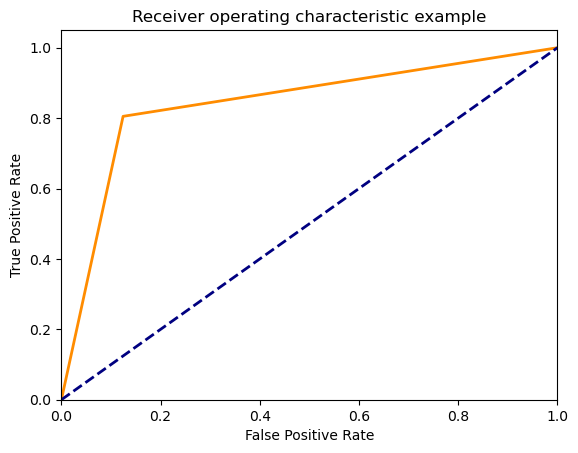

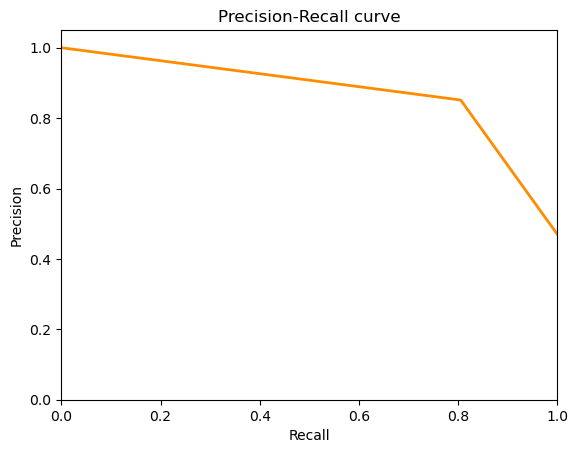

In [80]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, y_pred))

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='darkorange', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic example')

plt.show()

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, color='darkorange', lw=2)

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('Recall')

plt.ylabel('Precision')

plt.title('Precision-Recall curve')

plt.show()


